In [1]:
import numpy as np
import multiprocessing
import matplotlib.pyplot as plt
from tqdm import tqdm
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit_algorithms import VQE
from qiskit_algorithms.optimizers import L_BFGS_B, SPSA
from qiskit.primitives import Estimator
from qiskit_algorithms.utils import algorithm_globals
from qiskit_aer.primitives import Estimator as AerEstimator
from qiskit_nature.second_q.circuit.library import HartreeFock, UCCSD
from qiskit_nature.second_q.algorithms import GroundStateEigensolver
from qiskit import QuantumCircuit

## Building the H2 Molecule

A distance of 0.725 Angstrom is set between the 2 hydrogen atoms, and the second quantized hamiltonian of the system is calculated

In [2]:
driver = PySCFDriver(
    atom="H 0 0 0; H 0 0 0.725",
    basis="sto3g",
    charge=0,
    spin=0,
    unit=DistanceUnit.ANGSTROM,
)

es_problem = driver.run()

In [3]:
mapper = JordanWignerMapper()

In [4]:
print("Hamiltonian of Molecule:")
hamiltonian = es_problem.hamiltonian.second_q_op()
qubit_op = mapper.map(hamiltonian)
aux_op = mapper.map(es_problem.second_q_ops()[1])
for pauli, coeff in sorted(qubit_op.label_iter()):
    print(f"{coeff.real:+.8f} * {pauli}")

Hamiltonian of Molecule:
-0.80718366 * IIII
+0.17374013 * IIIZ
-0.23047453 * IIZI
+0.12148839 * IIZZ
+0.17374013 * IZII
+0.16940471 * IZIZ
+0.16658220 * IZZI
+0.04509381 * XXXX
+0.04509381 * XXYY
+0.04509381 * YYXX
+0.04509381 * YYYY
-0.23047453 * ZIII
+0.16658220 * ZIIZ
+0.17510657 * ZIZI
+0.12148839 * ZZII


## Building Noise Model
Noise model based on:
T1 (or longitudinal) relaxation time where a qubits state to decays from |1〉to |0〉within a certain amount of time
T2 (or transverse) relaxation time, or phase coherence time, describes how long the phase information of the superposition state of the qubit can be preserved for
Individual Gate Times
[https://www.researchgate.net/figure/The-gate-times-in-ns-for-all-supported-one-and-two-qubit-quantum-gates_tbl1_259212249]()

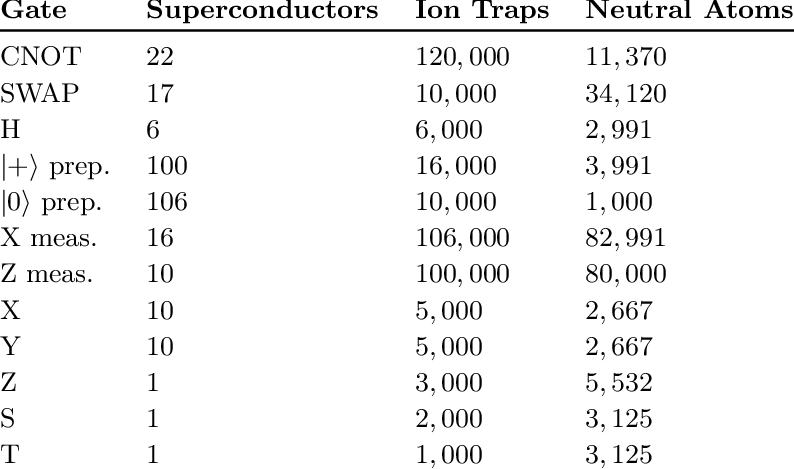

In [5]:
from IPython.display import Image
Image(filename='images/gate_time.png')

In [6]:
import numpy as np
from qiskit_aer.noise import (NoiseModel, QuantumError, ReadoutError, pauli_error, depolarizing_error, thermal_relaxation_error)

In [7]:
class ThermalNoiseModel(NoiseModel):
    def __init__(self, t1, t2):
        super().__init__()
        self.t1 = t1
        self.t2 = t2
        self.time_cx = 22
        self.time_swap = 17
        self.single_gate_times = {
            "h": 6,
            "x": 10,
            "y": 10,
            "measure": 10
        }

        self.add_errors()

    def add_errors(self):
        for gate, time in self.single_gate_times.items():
            self.add_all_qubit_quantum_error(thermal_relaxation_error(self.t1, self.t2, time), gate)
        self.add_all_qubit_quantum_error(thermal_relaxation_error(self.t1, self.t2, self.time_cx).expand(thermal_relaxation_error(self.t1, self.t2, self.time_cx)), "cx")
        self.add_all_qubit_quantum_error(thermal_relaxation_error(self.t1, self.t2, self.time_swap).expand(thermal_relaxation_error(self.t1, self.t2, self.time_swap)), "swap")

In [25]:
seed = 100

noisy_estimator = AerEstimator(
    backend_options={
        "method": "density_matrix",
        "coupling_map": [(0, 1), (1, 2), (2, 3), (3, 4)],
        "noise_model": ThermalNoiseModel(50e3, 75e3), # 80us for T1, 120us for T2
    },
    run_options={"seed": seed, "shots": 1024},
    transpile_options={"seed_transpiler": seed},
)

noiseless_estimator = AerEstimator(
    run_options={"seed": seed, "shots": 1024},
    transpile_options={"seed_transpiler": seed}
)

In [26]:
ansatz = UCCSD(
    es_problem.num_spatial_orbitals,
    es_problem.num_particles,
    mapper,
    initial_state=HartreeFock(
        es_problem.num_spatial_orbitals,
        es_problem.num_particles,
        mapper,
    ),
)

vqe_solver = VQE(noisy_estimator, ansatz, SPSA()) #, callback=store_intermediate_result)
vqe_solver.initial_point = [0.0] * ansatz.num_parameters

## Ansatz Circuit & Gates

In [27]:
for gate, cnt in ansatz.decompose(reps=3).count_ops().items():
    print(f"{gate.upper()} Gate - {cnt}")

H Gate - 80
CX Gate - 56
SDG Gate - 20
S Gate - 20
RZ Gate - 12
U Gate - 2


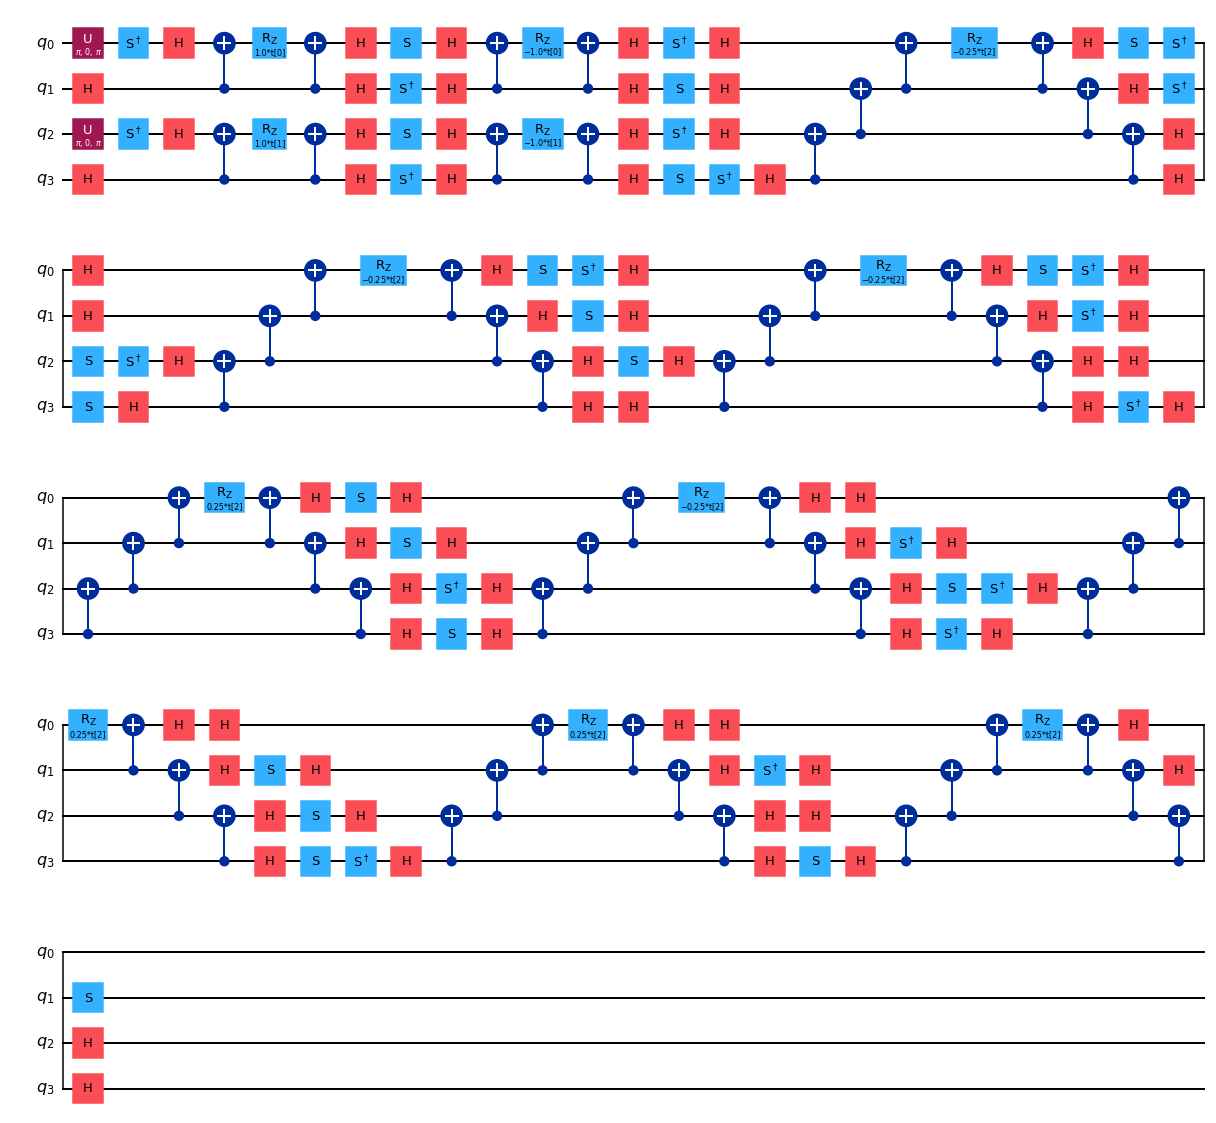

In [28]:
ansatz.decompose(reps=3).draw(output="mpl")

## Running the VQE

In [29]:
raw_result = vqe_solver.compute_minimum_eigenvalue(qubit_op, aux_op)
res = es_problem.interpret(raw_result)
res.total_energies[0]

-0.9194922231972892

In [30]:
calculated = res.eigenvalues[0] + res._nuclear_repulsion_energy
actual = res._hartree_fock_energy
print("Total Calculated Energy:", calculated)
print("Actual Energy:", res._hartree_fock_energy)
print(f"Percentage Error: {(calculated - actual) / calculated * 100:.2f}%")

Total Calculated Energy: -0.9194922231972892
Actual Energy: -0.6148699740425608
Percentage Error: 33.13%


## Try different distances between the atoms

Find the ground state energy when the distance between the 2 hydrogen atoms is varied.
Plot the graph of ground state energy against distance (and smoothing the graph), and find the minimum energy and its corresponding distance

In [31]:
distances = np.hstack((np.arange(0.2, 1.55, 0.05), np.arange(1.75, 4.25, 0.25)))
vqe_energies = []

for distance in tqdm(distances, desc="Calculating energies"):
    driver = PySCFDriver(
        atom=f"H 0 0 0; H 0 0 {distance}",
        basis="sto3g",
        charge=0,
        spin=0,
        unit=DistanceUnit.ANGSTROM,
    )
    es_problem = driver.run()
    qubit_op, aux_op = es_problem.second_q_ops()
    qubit_op, aux_op = mapper.map(qubit_op), mapper.map(aux_op)
    raw_result = vqe_solver.compute_minimum_eigenvalue(qubit_op, aux_op)
    res = es_problem.interpret(raw_result)
    vqe_energies.append(res.total_energies[0])

Calculating energies: 100%|██████████| 37/37 [01:18<00:00,  2.13s/it]


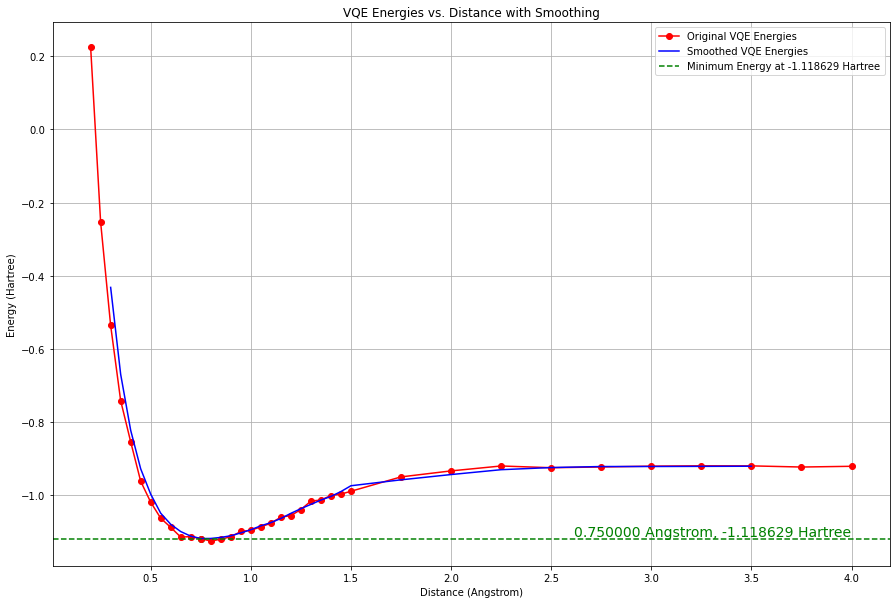

The minimum energy is -1.118629 Hartree at a distance of 0.750000 Angstrom


In [33]:
kernel_size = 5
kernel = np.ones(kernel_size) / kernel_size

# Apply convolution to smooth the energies
smoothed_energies = np.convolve(vqe_energies, kernel, mode='valid')

# Adjust distances to match the length of the smoothed energies
adjusted_distances = distances[(kernel_size-1)//2:-(kernel_size-1)//2] if kernel_size % 2 != 0 else distances[(kernel_size)//2:-(kernel_size)//2]

# Find the minimum energy and corresponding distance
min_energy = smoothed_energies.min()
min_energy_distance = adjusted_distances[smoothed_energies.argmin()]

# Plot the original and smoothed energies
plt.figure(figsize=(15, 10))
plt.plot(distances, vqe_energies, 'o-', label='Original VQE Energies', color='red')
plt.plot(adjusted_distances, smoothed_energies, '-', label='Smoothed VQE Energies', color='blue')

# Draw a horizontal line at the minimum energy point
plt.axhline(min_energy, color='green', linestyle='--', label=f'Minimum Energy at {min_energy:.6f} Hartree')
plt.scatter(min_energy_distance, min_energy, color='green')  # Mark the minimum point
plt.text(distances[-1], min_energy, f'{min_energy_distance:.6f} Angstrom, {min_energy:.6f} Hartree', color='green', fontsize=14, ha='right', va='bottom')


plt.xlabel('Distance (Angstrom)')
plt.ylabel('Energy (Hartree)')
plt.title('VQE Energies vs. Distance with Smoothing')
plt.legend()
plt.grid(True)
plt.show()

print(f"The minimum energy is {min_energy:.6f} Hartree at a distance of {min_energy_distance:.6f} Angstrom")